# Prelim

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import json
import pickle
import glob

import xgboost as xgb

from sklearn.model_selection import KFold
from sklearn.preprocessing import TargetEncoder

import random
from itertools import chain, combinations
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
train               = pd.merge(
                                pd.read_csv('data/train.csv') , 
                                pd.read_csv('data/training_extra.csv'), 
                                how='outer'
                                )

In [ ]:
# helper functions
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(2,4,1))

# get top 10 gain features from run run_num
def get_gain_combos(run_num, sample_size):
    gains=[]
    gain_set = set()
    for fold_num in range(1,5):
        with open('experiments/run%s/gain%s.json' % (run_num, fold_num), "rb") as json_file:
            gains.append(list(json.load(json_file).keys())[0:10])

    for a in gains:
        for b in a:
            gain_set.add(b)

    gains = list(gain_set)
    gain_combos = list(powerset(gains))
    return random.sample(gain_combos, sample_size)

def generate_submission(run_num):
    sample_submission   = pd.read_csv('data/sample_submission.csv')
    test                = pd.read_csv('data/test.csv')
    
    test = feature_engineering(test, run_num=run_num, training=False)

    df = pd.DataFrame()
    model_list = glob.glob('experiments/run%s/model*.pkl' % run_num)
    for i, model in enumerate(model_list):
        df[i] = pickle.load(open(model, "rb")).predict(test)

    i=0
    while os.path.exists('submissions/submission_run%s.csv' % run_num):
        i+=1

    sample_submission['Price'] = df.mean(axis=1)
    sample_submission.to_csv('submissions/submission_run%s.csv' % run_num, index=False)

def log_training(model, run_num):

    fold_num=0
    while os.path.exists('experiments/run%s/lossplot%s.png' % (run_num, fold_num) ):
        fold_num+=1

    # get results
    results = model.evals_result()
    gain = model.get_booster().get_score(importance_type='gain')

    # get top 15 features as measured by gain score for plot generation
    gain_sorted = dict(sorted(gain.items(), key=lambda item: item[1]))
    keys = list(gain_sorted.keys())[0:15]
    values = list(gain_sorted.values())[0:15]

    # log gain in json - use later to get all features from model and top N
    with open('experiments/run%s/gain%s.json' % (run_num, fold_num), "w+") as json_file:
        json.dump(gain_sorted, json_file)
    
    #create gain plot
    plt.figure(figsize=(20,6))
    plt.bar(keys, values, color='skyblue')
    plt.xlabel('Keys')
    plt.ylabel('Values')
    plt.title('Dictionary Plot')
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--')
    plt.savefig('experiments/run%s/gainplot%s.png' % (run_num, fold_num) )

    #create loss plot
    plt.figure(figsize=(10,7))
    plt.plot(results["validation_0"]["rmse"], label="Training loss")
    plt.plot(results["validation_1"]["rmse"], label="Validation loss")
    plt.title('Loss: run %s, split %s' % (run_num, fold_num))
    plt.xlabel("Number of trees")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig('experiments/run%s/lossplot%s.png' % (run_num, fold_num) )

    with open('experiments/run%s/model%s.pkl' % (run_num, fold_num), mode='wb+') as file:
        pickle.dump(model, file)

def feature_engineering(df, **kwargs):
    run_num             = kwargs.get('run_num')
    training            = kwargs.get('training')
    target_encoding     = kwargs.get('target_encoding')
    one_hot_encoding    = kwargs.get('one_hot')
    random_interactions = kwargs.get('random_interactions')


# target encode categorical features - leads to worse performance in testing and very little difference in submission
    cat_cols = list( df.select_dtypes(exclude=np.number).columns )

    if target_encoding:
        if training:
            enc = TargetEncoder(target_type='continuous')
            enc.fit(X = df[cat_cols], y=y)
            with open('experiments/run%s/encoder.pkl' % run_num, 'wb+') as file:
                pickle.dump(enc, file)
        else: 
            with open('experiments/run%s/encoder.pkl' % run_num, 'rb') as file:
                enc = pickle.load(file)

        values = pd.DataFrame(enc.transform(df[cat_cols]))
        df = pd.concat([df, values], axis=1)  

    # one-hot encode categorical features
    if one_hot_encoding:
        df = pd.get_dummies(df, dtype=float, dummy_na=True)
        cat_cols = df.select_dtypes(include='object').columns
        df[cat_cols] = df[cat_cols].astype("float")

    # add randomly sampled interaction features
    if random_interactions:
        if training:
            interaction_features = get_gain_combos(1, 100)
            with open('experiments/run%s/interaction_features.pkl' % run_num, mode='wb+') as file:
                pickle.dump(interaction_features, file)
        else:
            with open('experiments/run%s/interaction_features.pkl' % run_num, mode='rb') as file:
                interaction_features = pickle.load(file)
                
        for group in interaction_features:
            group=list(group)
            group_name = "*".join(group).strip()
            df[group_name] = df[group].prod(axis=1)

    # other feature engineering strategies
    df['weight_sq'] = df['Weight Capacity (kg)'] ** 2

    # df['both_waterproof_laptop'] = df['Waterproof_Yes'] * df['Laptop Compartment_Yes']
    # df['both_waterproof_large'] = df['Waterproof_Yes'] * df['Size_Large']
    # df['black_puma'] = df['Brand_Puma'] * df['Color_Black']
    # df['large_nike'] = df['Brand_Nike'] * df['Size_Large']

    # drop target and id
    drop_cols = ['Price', 'id']
    
    if not one_hot_encoding:
        drop_cols += cat_cols

    for col in drop_cols:
        try:
            df.drop(columns=[col], inplace=True)
        except KeyError:
            pass

    return df   

[0]	validation_0-rmse:38.92790	validation_1-rmse:38.97885
[1]	validation_0-rmse:38.92733	validation_1-rmse:38.97828
[2]	validation_0-rmse:38.92677	validation_1-rmse:38.97772
[3]	validation_0-rmse:38.92622	validation_1-rmse:38.97717
[4]	validation_0-rmse:38.92568	validation_1-rmse:38.97663
[5]	validation_0-rmse:38.92515	validation_1-rmse:38.97610
[6]	validation_0-rmse:38.92463	validation_1-rmse:38.97558
[7]	validation_0-rmse:38.92412	validation_1-rmse:38.97507
[8]	validation_0-rmse:38.92363	validation_1-rmse:38.97457
[9]	validation_0-rmse:38.92314	validation_1-rmse:38.97408
[10]	validation_0-rmse:38.92266	validation_1-rmse:38.97360
[11]	validation_0-rmse:38.92219	validation_1-rmse:38.97312
[12]	validation_0-rmse:38.92173	validation_1-rmse:38.97266
[13]	validation_0-rmse:38.92128	validation_1-rmse:38.97220
[14]	validation_0-rmse:38.92083	validation_1-rmse:38.97176
[15]	validation_0-rmse:38.92040	validation_1-rmse:38.97132
[16]	validation_0-rmse:38.91997	validation_1-rmse:38.97089
[17]	va

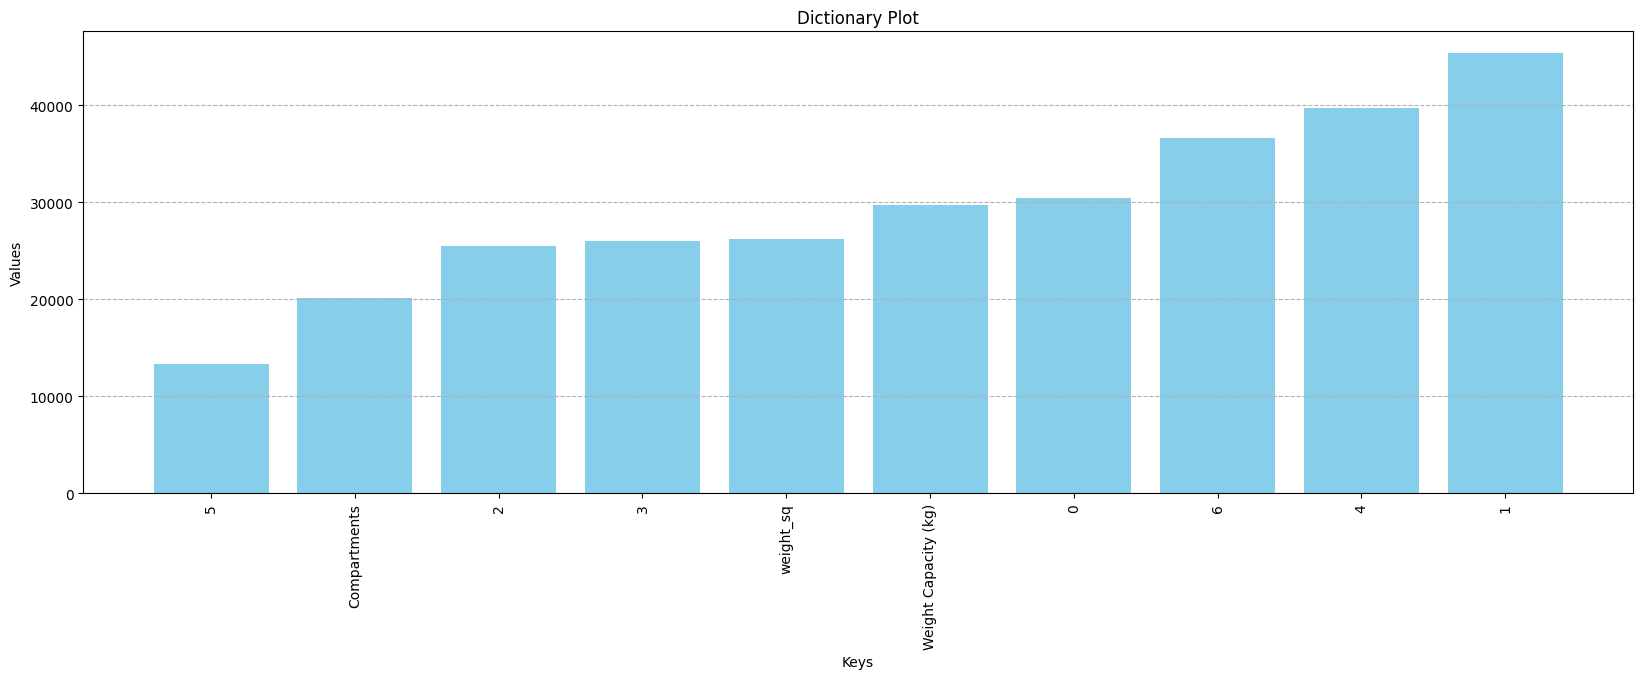

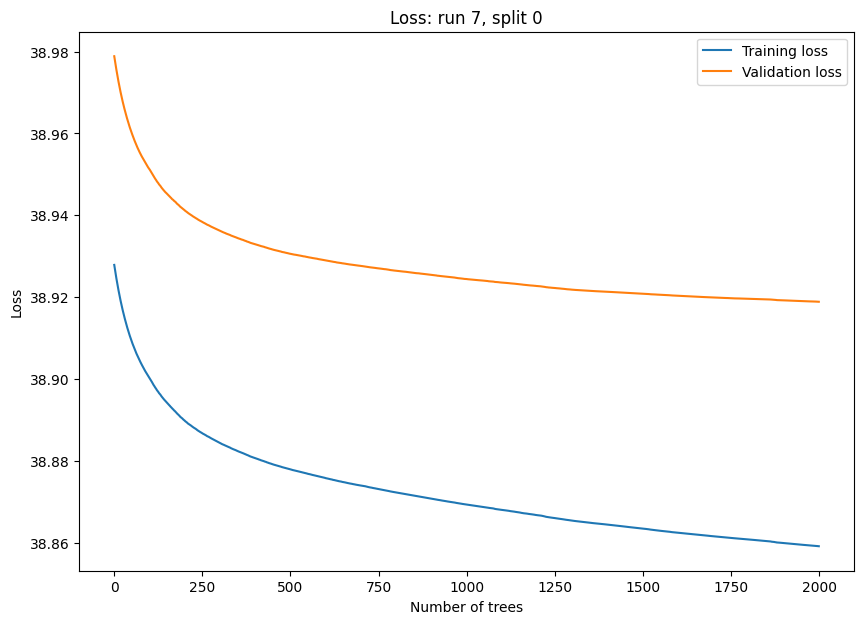

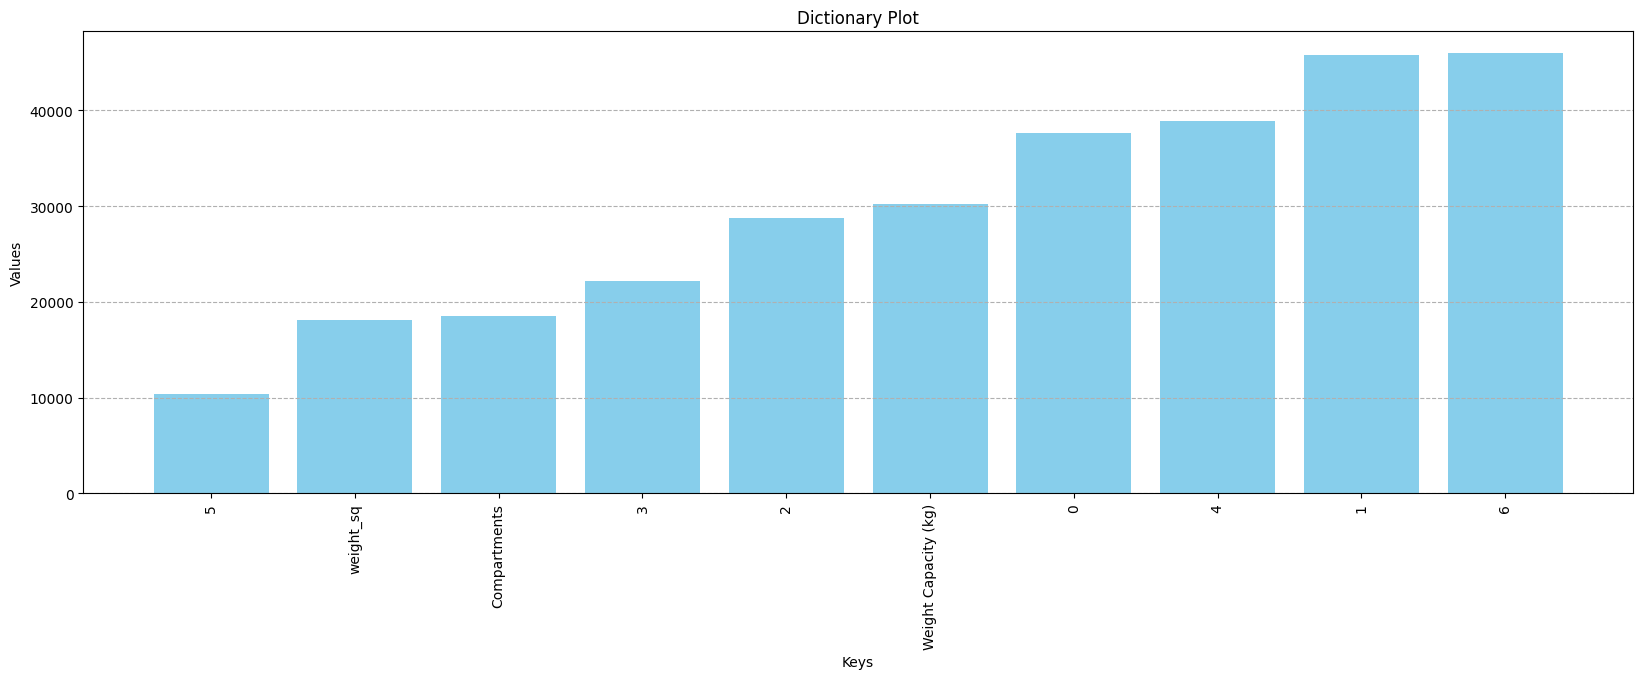

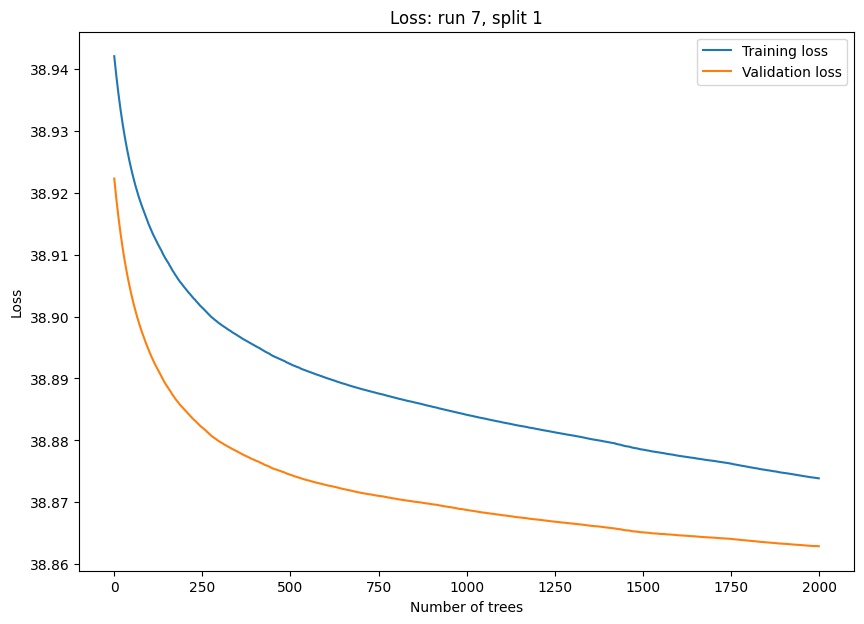

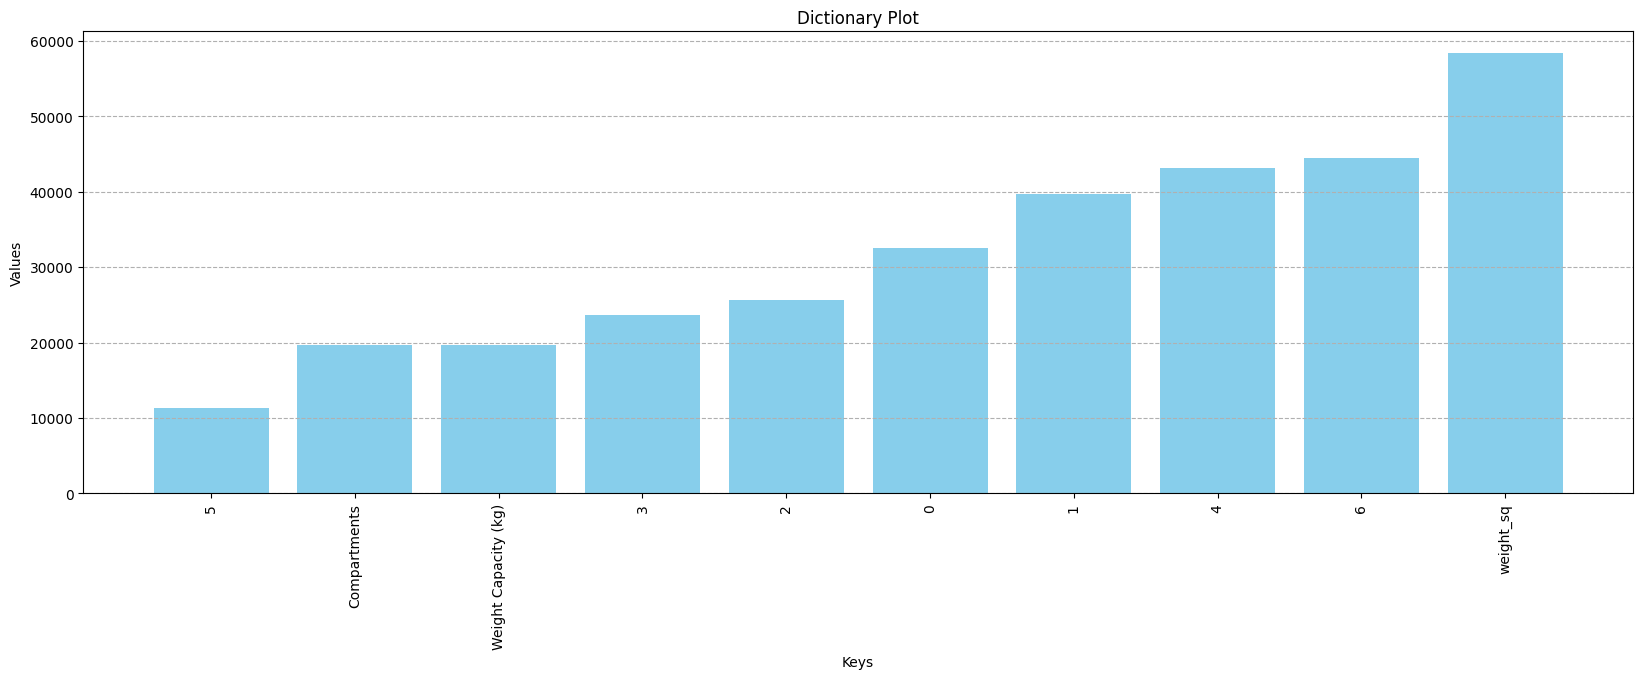

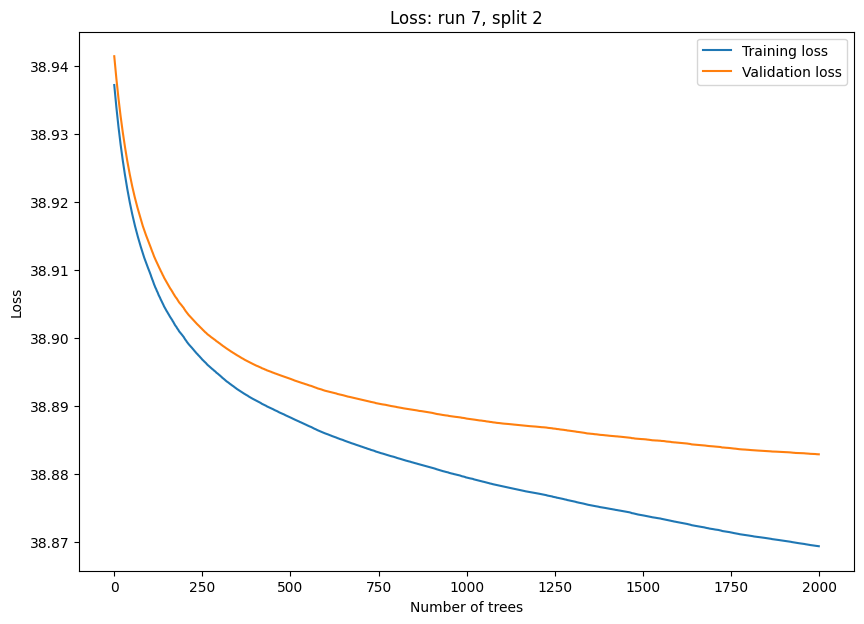

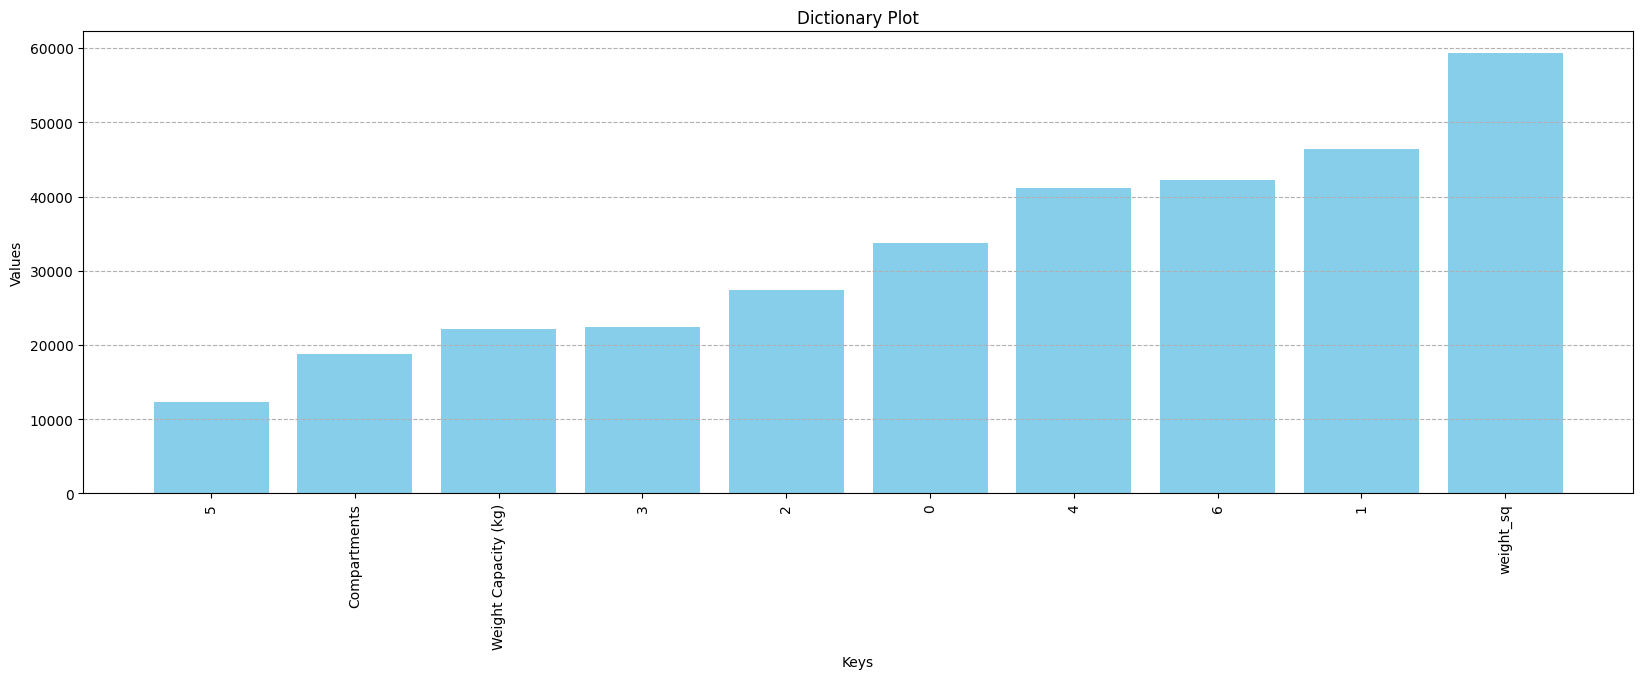

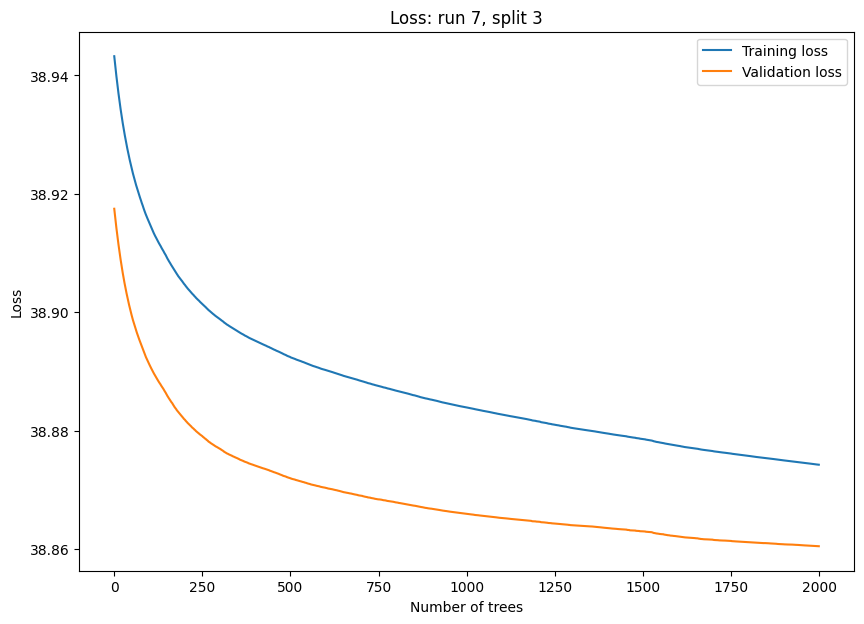

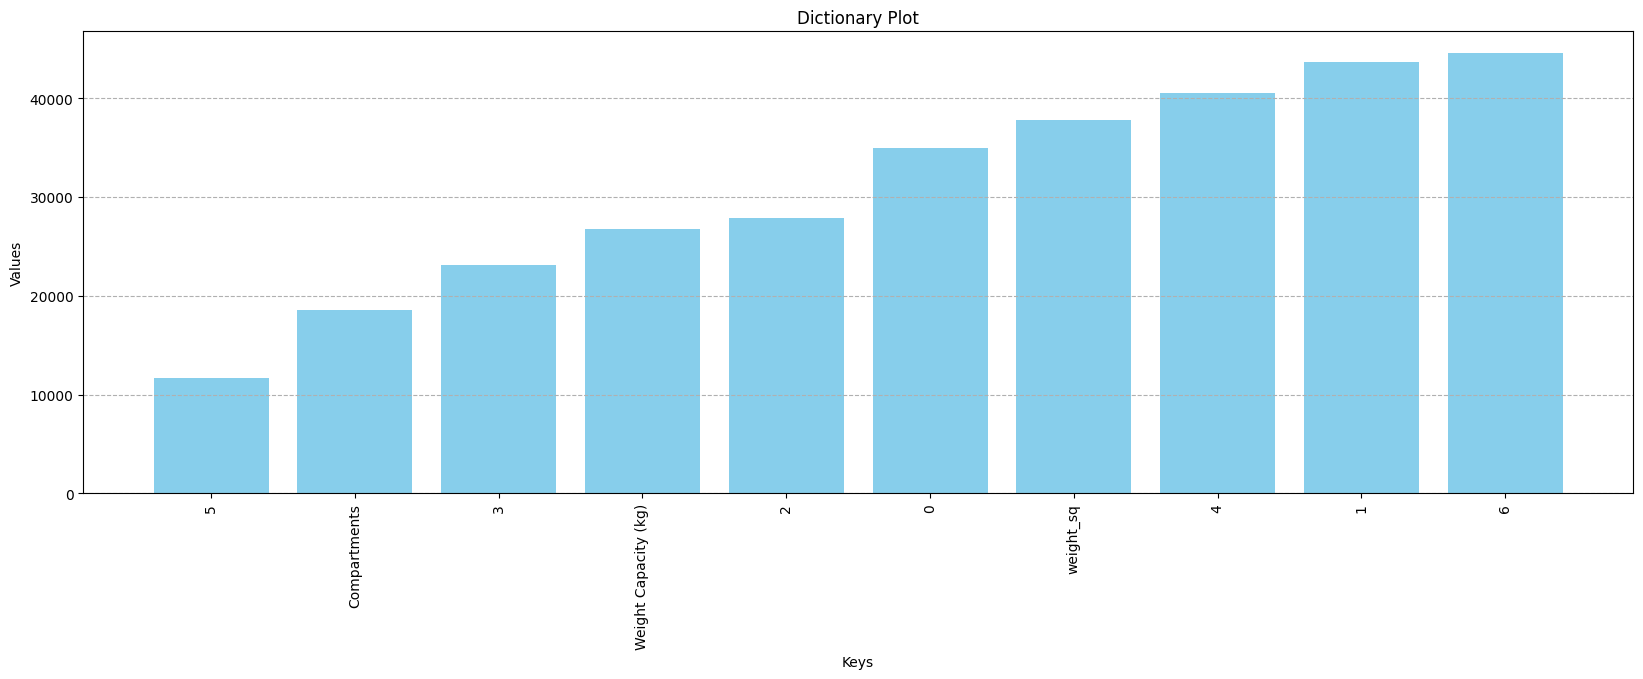

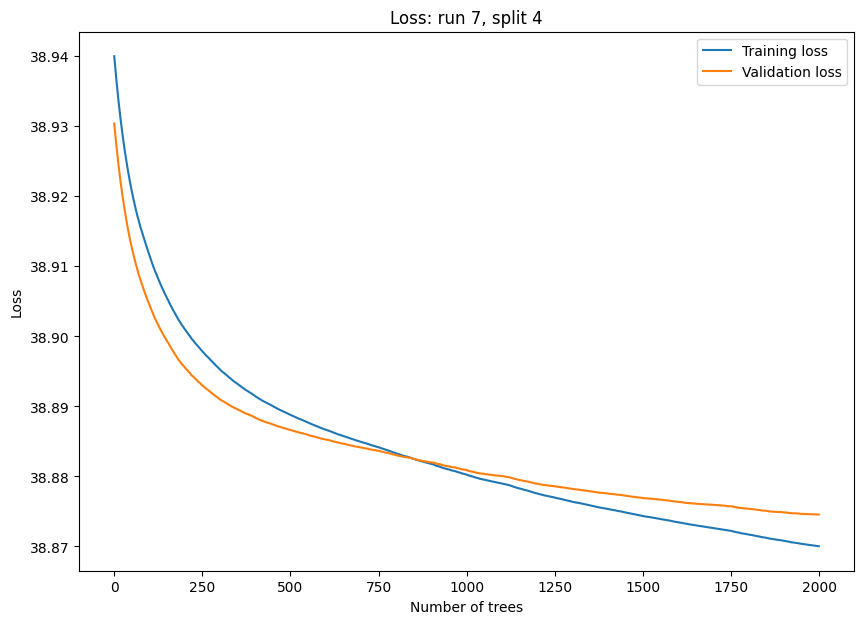

In [ ]:
# create experiment directory
run_num=0
while os.path.exists('experiments/run%s' % run_num):
    run_num+=1
os.mkdir('experiments/run%s' % run_num)

# grab data to be altered
X = train.copy(deep=True)
y = train['Price'].copy(deep=True)

# X = feature_engineering(X, run_num=run_num, training=True, target_encoding=True)

model = xgb.XGBRegressor(
                    device='cuda',
                    n_estimators = 2000,
                    max_depth = 4,
                    learning_rate= .01,
                    objective='reg:squarederror',
                    early_stopping_rounds= 20
)

kf = KFold(n_splits=5)
for i, (train_index, val_index) in enumerate(kf.split(X)):
    final_error_train = [] #train error in first entry, val error in second
    final_error_val = []

    


    X_train     = X.iloc[train_index]
    X_val       = X.iloc[val_index]
    y_train     = y.iloc[train_index]
    y_val       = y.iloc[val_index]

    model.fit( X_train, y_train,  eval_set=[(X_train, y_train), (X_val, y_val)]) 

    log_training(model, run_num)

    results = model.evals_result()
    final_error_train.append( results['validation_0']['rmse'][-1] )
    final_error_val.append( results['validation_1']['rmse'][-1] )

mean_train_error = sum(final_error_train) / len(final_error_train)
mean_val_error = sum(final_error_val) / len(final_error_val)
print('Average errors: Training %s, Validation %s' % (mean_train_error, mean_val_error ))

# update spreadsheet with run scores so far
current_scores = pd.DataFrame()
current_scores['run'] = [run_num]
current_scores['mean_train_error'] = [mean_train_error]
current_scores['mean_val_error'] = [mean_val_error]
scores = pd.read_csv('experiments/average_scores.csv')
scores = pd.concat([scores, current_scores])
scores.to_csv('experiments/average_scores.csv', index=False)

In [17]:
generate_submission(5)

c:\Users\19368\anaconda3\envs\Kaggle\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:23:16] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [ ]:
from scipy.stats import chi2_contingency
import seaborn as sns

def ch_calculate(df):
    factors_paired = [(i,j) for i in df.columns.values for j in df.columns.values] 

    chi2, p_values =[], []

    for f in factors_paired:
        if f[0] != f[1]:
            chitest = chi2_contingency(pd.crosstab(df[f[0]], df[f[1]]))   
            chi2.append(chitest[0])
            p_values.append(chitest[1])
        else:      # for same factor pair
            chi2.append(0)
            p_values.append(0)

    chi2 = np.array(chi2).reshape((len(df.columns),len(df.columns))) # shape it as a matrix
    chi2 = pd.DataFrame(chi2, index=df.columns.values, columns=df.columns.values) # then a df for convenience
    #all the p-values are essentially zero
    fig, ax = plt.subplots(figsize=(10,6))
    sns.heatmap(chi2, annot = True)
    plt.show()
    

In [ ]:
ch_calculate(X[['Material', 'Brand', 'Size', 'Waterproof', 'Style']])